In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.colheader_justify', 'center')

In [98]:
def load_data(path : str )-> pd.DataFrame:
    return pd.read_csv(PATH, engine='pyarrow', dtype_backend='pyarrow')
PATH = "job_data_merged_1.csv"
data = load_data(PATH)
data.head()

,,CT,place,Location,City,T
0,0,Business Analyst,Remote,United Kingdom,Operations,Full time
1,1,Business Analyst,Remote,"Makati, Metro Manila, Philippines",Aux HQ,Full time
2,2,Business Analyst,On-site,"Al-Dajeej, Al Farwaniyah Governorate, Kuwait",PWC Technologies,Full time
3,3,Business Analyst,On-site,"London, England, United Kingdom","Consultants, Advisory",Full time
4,4,Business Analyst,Remote,United Kingdom,Operations,Full time


In [99]:
def change_name_column(df:pd.DataFrame)->pd.DataFrame:
    return df.rename(columns={
        "":'',
        'CT':'Category',
        'place':'Workplace',
        'City':'Department',
        'T': 'Type'
    })

In [100]:
def change_data_type(df: pd.DataFrame) -> pd.DataFrame:
    return df.astype({
        'Category':'category',
        'Workplace':'category',
        'Type':'category',
        'Department':'category',
        'Location':'category'
    })

In [101]:
# Preprocess the data
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(df.columns[0], axis=1)
    df = change_name_column(df)
    df = change_data_type(df)
    df = df.drop_duplicates()
    return df.reset_index(drop=True)


data = preprocess_data(data.copy())

In [102]:
data.head()

,Category,Workplace,Location,Department,Type
0,Business Analyst,Remote,United Kingdom,Operations,Full time
1,Business Analyst,Remote,"Makati, Metro Manila, Philippines",Aux HQ,Full time
2,Business Analyst,On-site,"Al-Dajeej, Al Farwaniyah Governorate, Kuwait",PWC Technologies,Full time
3,Business Analyst,On-site,"London, England, United Kingdom","Consultants, Advisory",Full time
4,Business Analyst,Remote,"London, England, United Kingdom",Change & Innovation,<NA>


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Category    672 non-null    category
 1   Workplace   648 non-null    category
 2   Location    644 non-null    category
 3   Department  575 non-null    category
 4   Type        576 non-null    category
dtypes: category(5)
memory usage: 36.3 KB


In [104]:
data = data.dropna()
print(data.isna().sum())
print(len(data))
data.head()

Category      0
Workplace     0
Location      0
Department    0
Type          0
dtype: int64
483


,Category,Workplace,Location,Department,Type
0,Business Analyst,Remote,United Kingdom,Operations,Full time
1,Business Analyst,Remote,"Makati, Metro Manila, Philippines",Aux HQ,Full time
2,Business Analyst,On-site,"Al-Dajeej, Al Farwaniyah Governorate, Kuwait",PWC Technologies,Full time
3,Business Analyst,On-site,"London, England, United Kingdom","Consultants, Advisory",Full time
5,Business Analyst,On-site,"Islamabad, Islamabad Capital Territory, Pakistan","Data & Strategy, Performance Analytics",Full time


In [105]:
unique_Cate=data['Category'].unique().tolist()
unique_Cate

['Business Analyst',
 'Cloud',
 'Data Scientist',
 'HR',
 'Software Developer',
 'UI/UX']

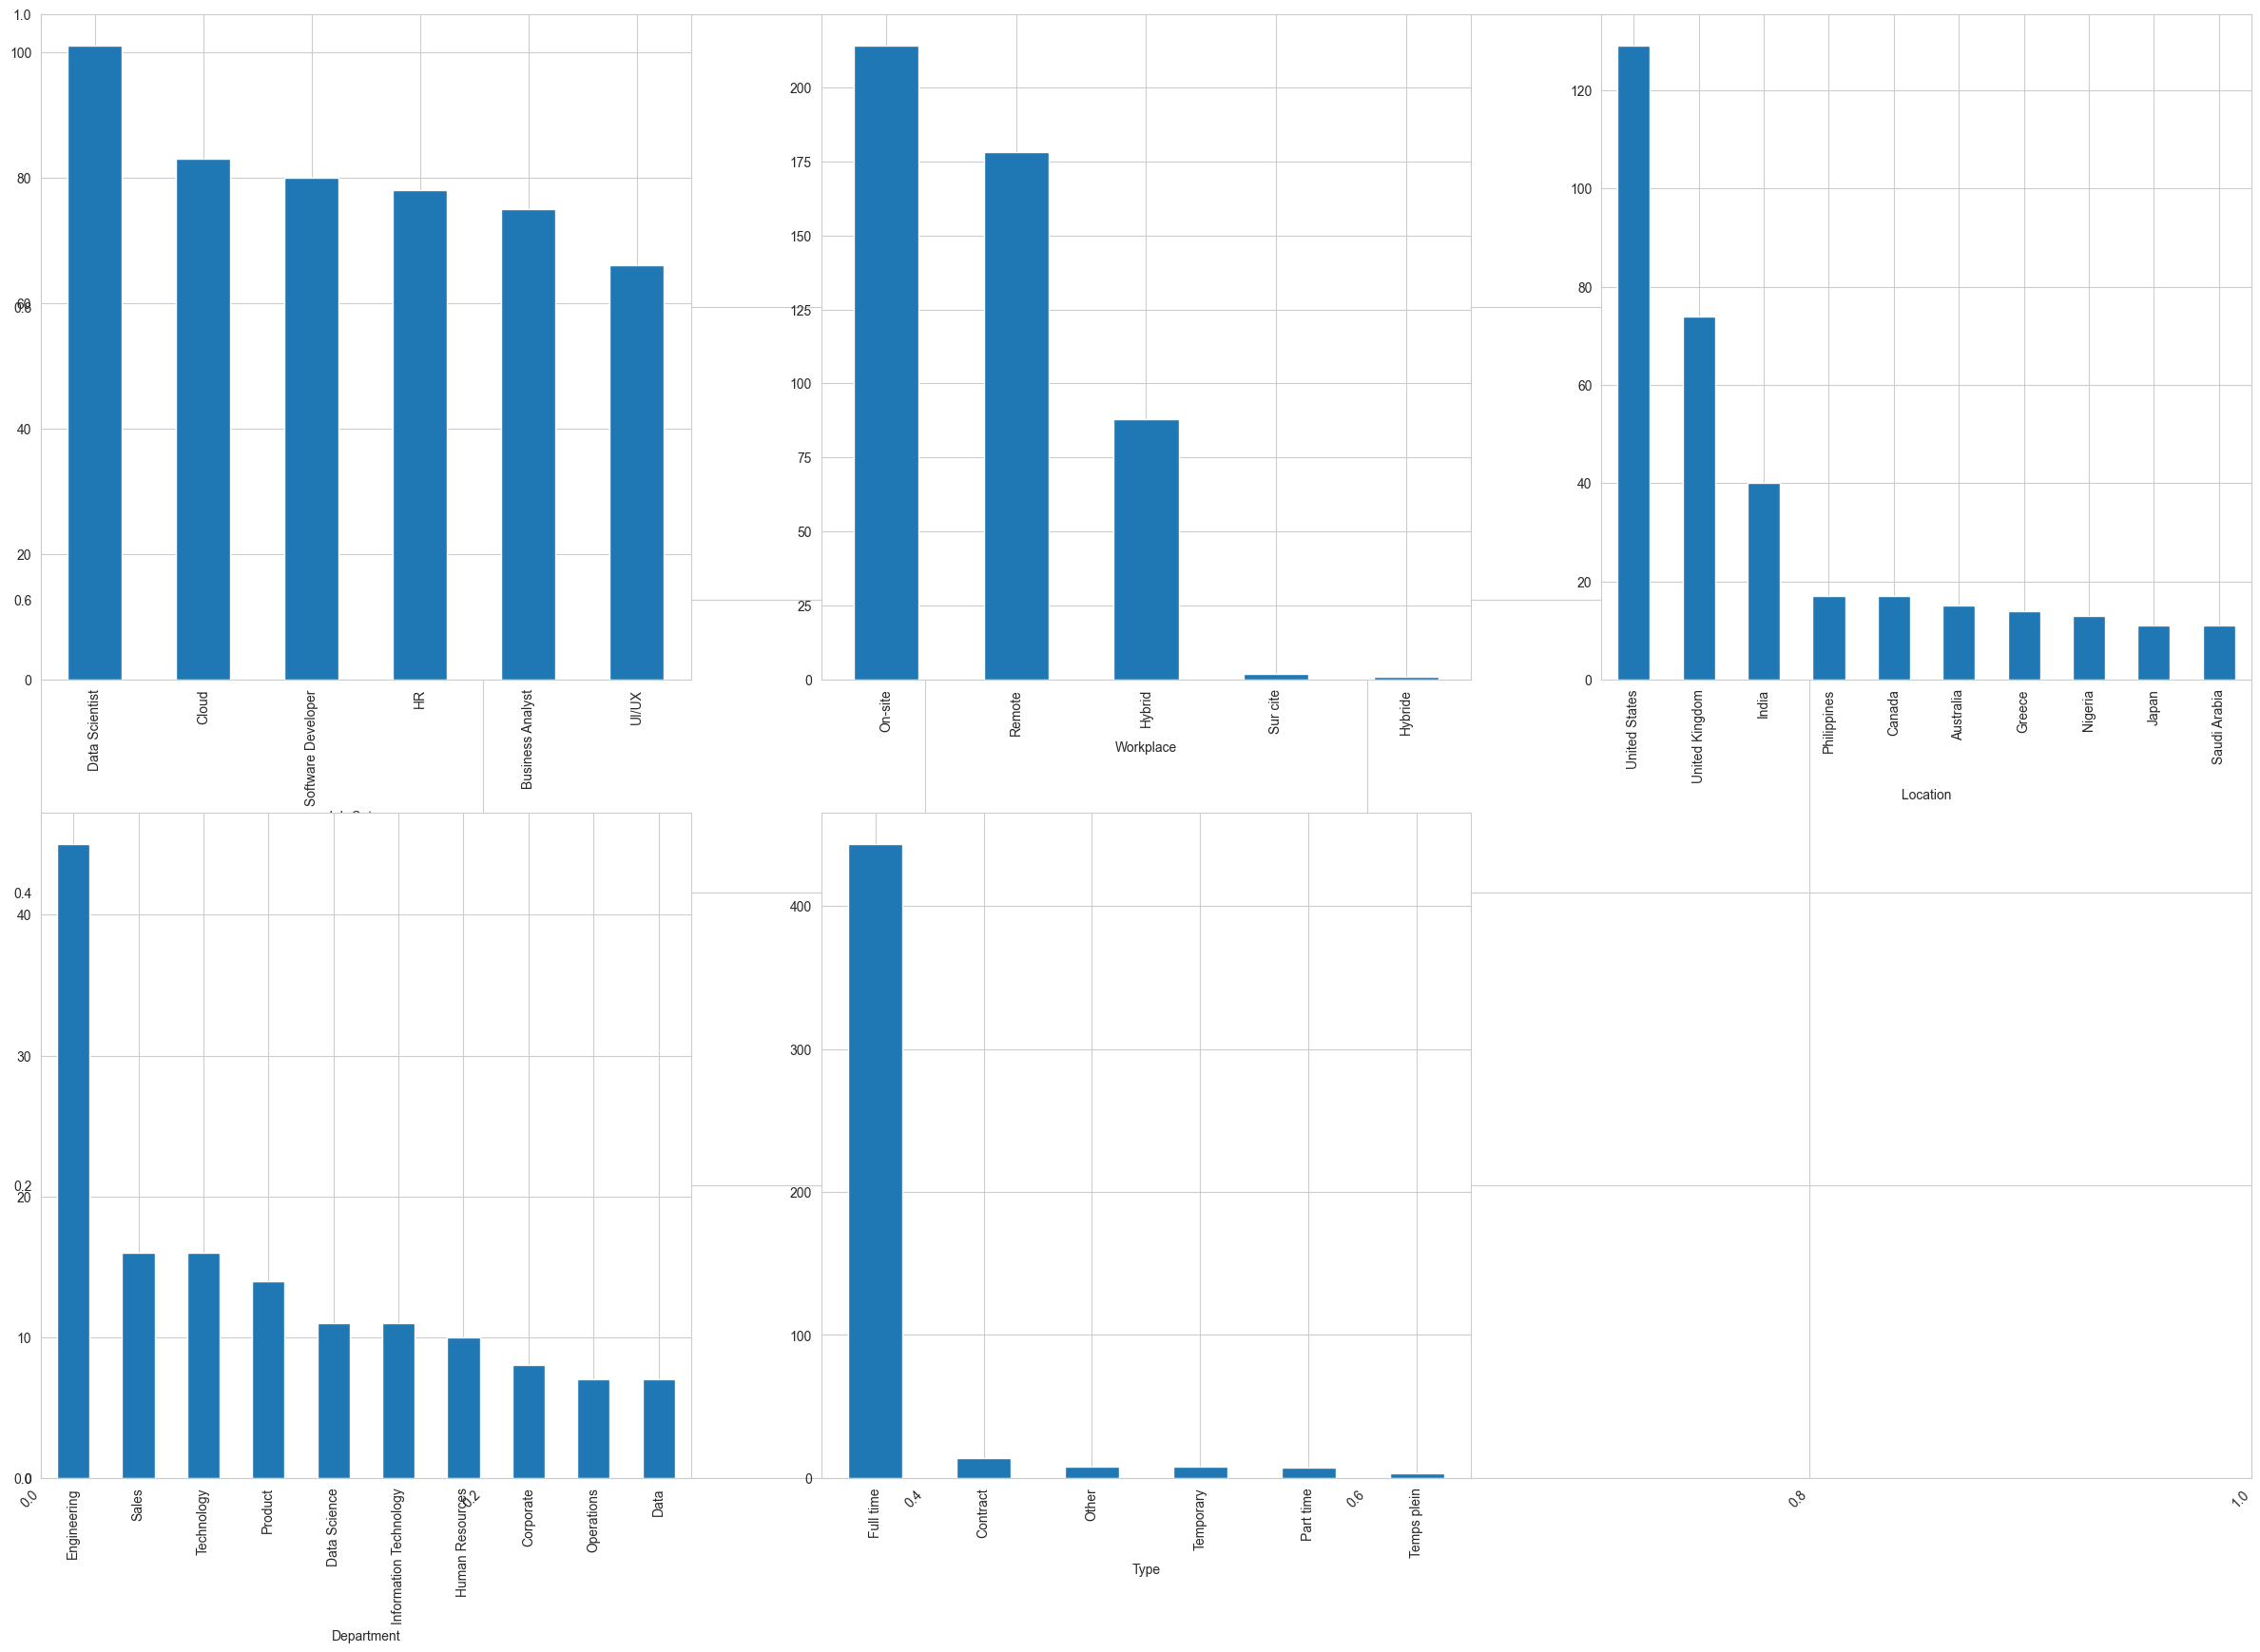

In [106]:
plt.figure(figsize=(30,20))
plt.xticks(rotation=45, ha='right')

plt.subplot(2,3,1)
data['Category'].value_counts().plot(kind='bar')
plt.xlabel('Job Category')


plt.subplot(2,3,2)
data['Workplace'].value_counts().plot(kind='bar')
plt.xlabel('Workplace')

plt.subplot(2,3,3)
data['Country'] = data['Location'].str.split(',').str[-1].str.strip()
data['Country'].value_counts()[:10].plot(kind='bar')
plt.xlabel('Location')

plt.subplot(2,3,4)
data['Department'].value_counts()[:10].plot(kind='bar')
plt.xlabel('Department')

plt.subplot(2,3,5)
data['Type'].value_counts()[:10].plot(kind='bar')
plt.xlabel('Type')

plt.show()

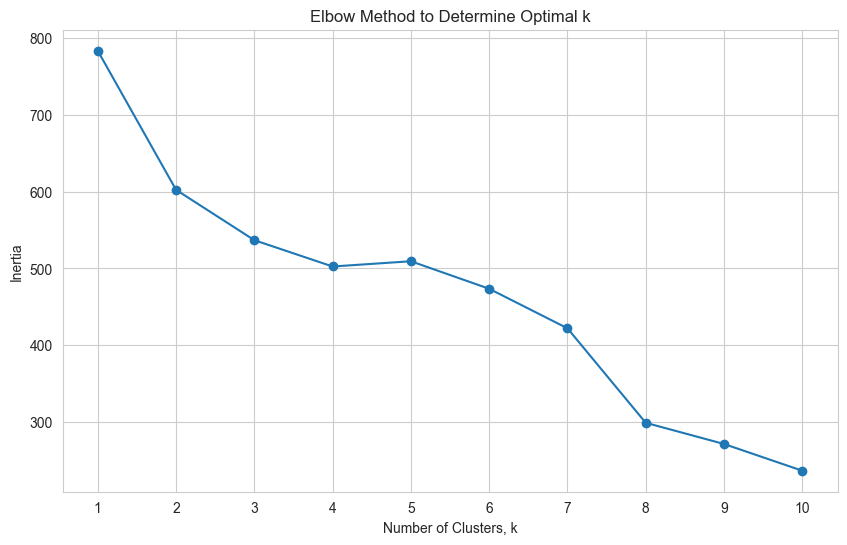

In [108]:
encoder = OneHotEncoder()
encoded_features = encoder.fit_transform(data[['Category', 'Workplace', 'Type']])

inertia = []
k_values = range(1, 11) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(encoded_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, '-o')
plt.title('Elbow Method to Determine Optimal k')
plt.xlabel('Number of Clusters, k')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [109]:
kmeans_final = KMeans(n_clusters=4, random_state=42)
kmeans_final.fit(encoded_features)

data['Cluster'] = kmeans_final.labels_

cluster_summary = data.groupby('Cluster').agg({
    'Category': lambda x: x.mode()[0],
    'Workplace': lambda x: x.mode()[0], 
    'Type': lambda x: x.mode()[0],       
    'Location': 'count'
}).rename(columns={'Location': 'Count'})

cluster_summary

,Category,Workplace,Type,Count
Cluster,,,,
0,Data Scientist,Hybrid,Full time,168
1,Cloud,Remote,Full time,107
2,HR,On-site,Full time,172
3,UI/UX,Remote,Full time,36


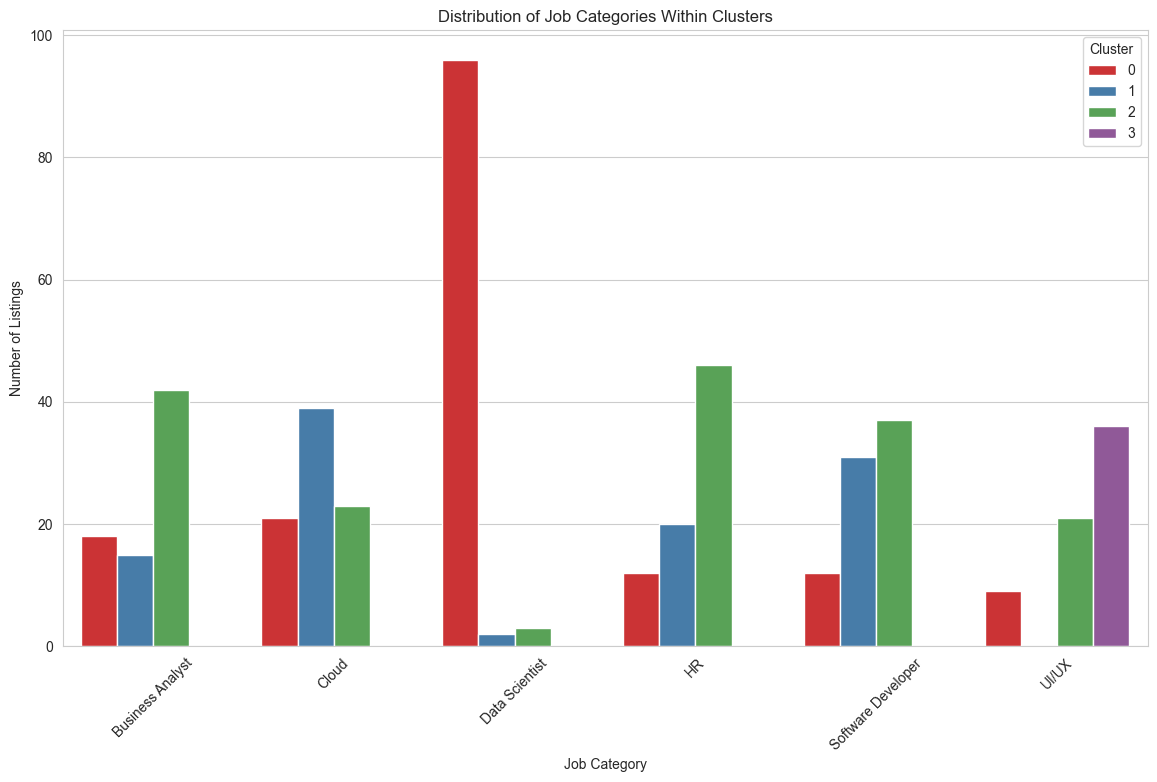

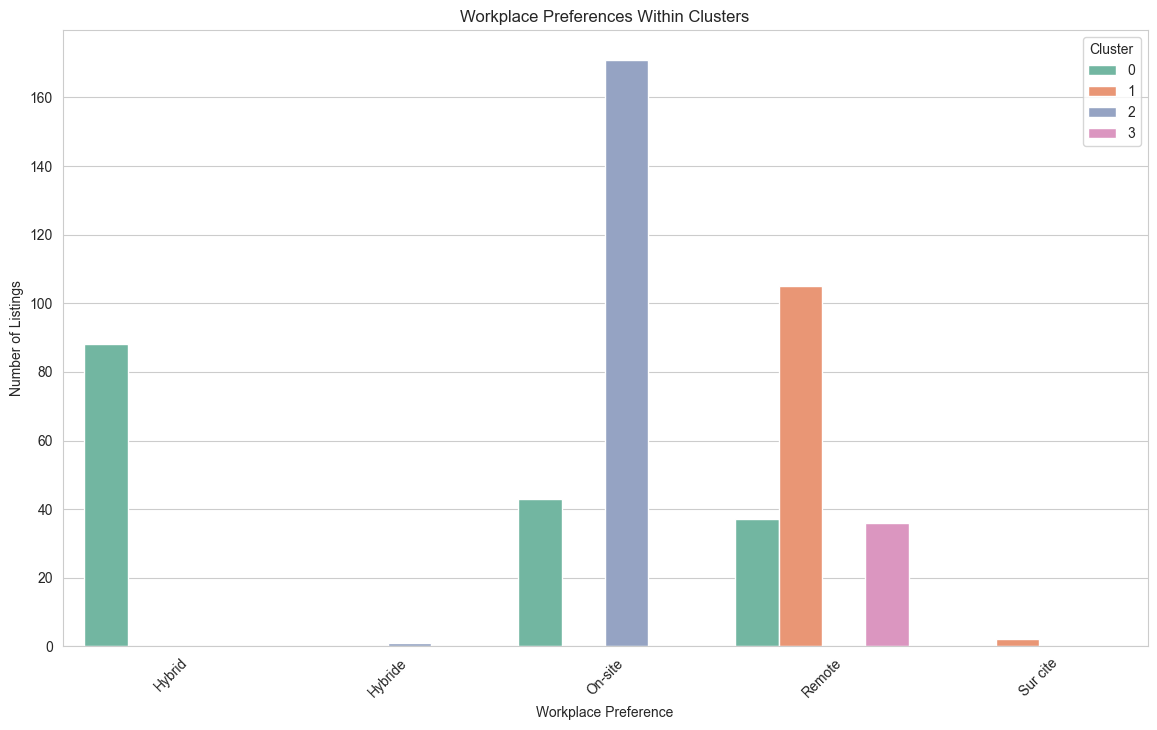

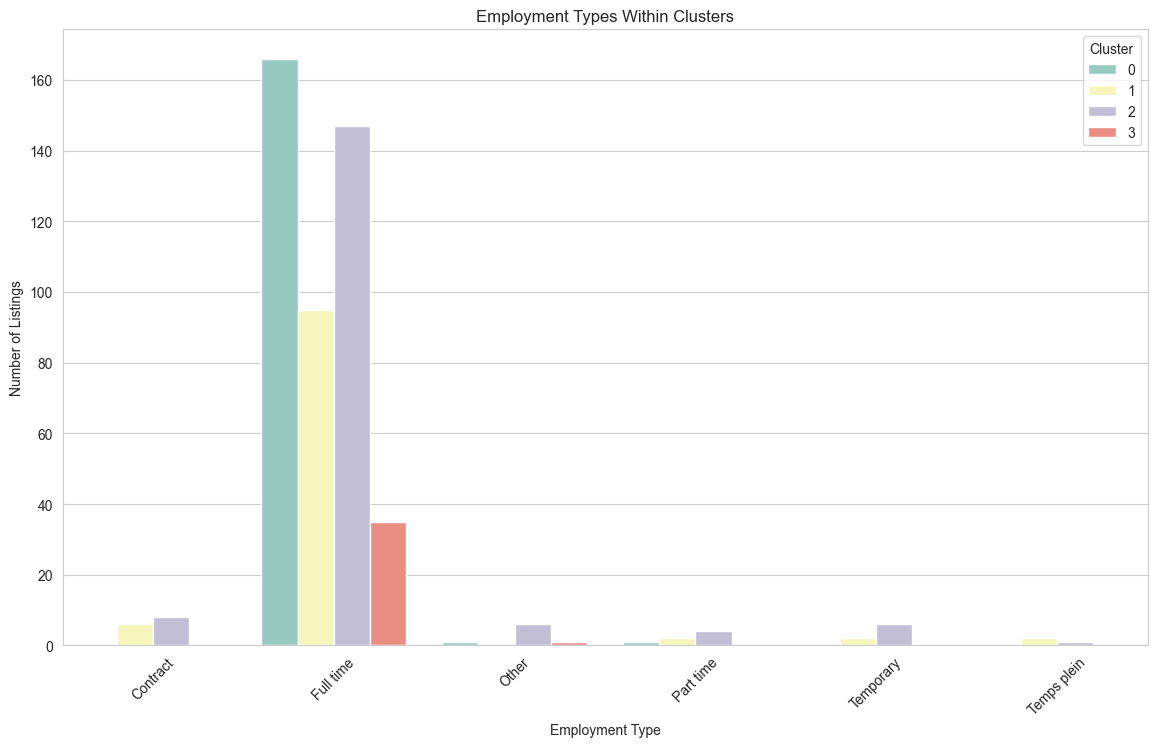

In [110]:
plt.figure(figsize=(14, 8))
sns.countplot(data=data, x='Category', hue='Cluster', palette='Set1')
plt.title('Distribution of Job Categories Within Clusters')
plt.xlabel('Job Category')
plt.ylabel('Number of Listings')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 8))
sns.countplot(data=data, x='Workplace', hue='Cluster', palette='Set2')
plt.title('Workplace Preferences Within Clusters')
plt.xlabel('Workplace Preference')
plt.ylabel('Number of Listings')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 8))
sns.countplot(data=data, x='Type', hue='Cluster', palette='Set3')
plt.title('Employment Types Within Clusters')
plt.xlabel('Employment Type')
plt.ylabel('Number of Listings')
plt.legend(title='Cluster')
plt.xticks(rotation=45)
plt.show()

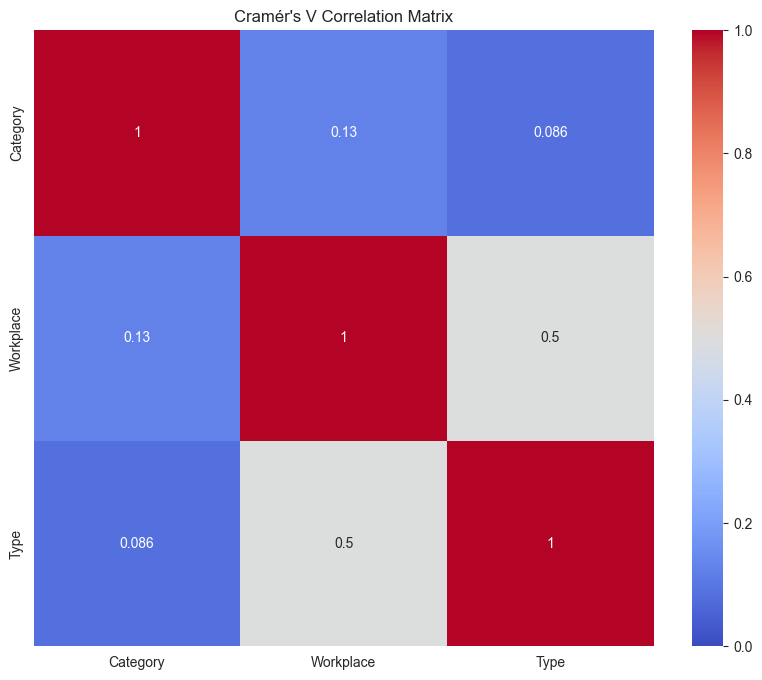

In [111]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

variables = ['Category', 'Workplace', 'Type']
cramers_v_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), index=variables, columns=variables)

for col1 in variables:
    for col2 in variables:
        cramers_v_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

cramers_v_matrix
# Visualizing the Cramér's V correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Correlation Matrix")
plt.show()